# Detección de Anomalías

En esta sesión vamos a usar un set de datos para detectar fraude en el uso de tarjetas de crédito. Los datos fueron originalmente tomados de Kaggle:

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Sin embargo, por motivos de almacenamiento y eficiencia computacional, el conjunto fue reducido tanto en número de muestras como en características, preservando las propiedades esenciales del problema original para que la actividad pueda desarrollarse con éxito.

Durante la sesión, exploraremos tres enfoques distintos para detectar anomalías:

1. Un modelo base estadístico basado en los valores Z de las observaciones.

2. K-means, un método de clustering o agrupamiento clásico y relativamente interpretable.

3. Un autoencoder, una red neuronal no supervisada entrenada para reconstruir los datos normales y detectar anomalías mediante el error de reconstrucción.

In [1]:
# Importamos las librerías necesarias

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df =pd.read_csv("creditcard_sample.csv")
df.head()


,V4,V11,V12,V14,V17,Amount,Class
0,9.505594,5.299236,-10.834006,-9.373859,-19.236292,364.19,1
1,-1.385729,-0.087670,0.979427,-0.217884,0.126956,520.12,0
2,-1.029950,0.543827,0.112453,-0.245772,-0.533172,31.00,0
3,-0.349504,-1.328335,0.223621,-0.550875,0.502195,1.50,0
4,0.327269,0.942162,0.850038,0.592634,-0.471867,0.89,0


In [3]:
df.dtypes

V4        float64
V11       float64
V12       float64
V14       float64
V17       float64
Amount    float64
Class       int64
dtype: object

In [4]:
df.isnull().sum()

V4        0
V11       0
V12       0
V14       0
V17       0
Amount    0
Class     0
dtype: int64

In [5]:
df["Class"].value_counts()

Class
0    49917
1       83
Name: count, dtype: int64

In [6]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

## Parte 1: Modelo Base (Z-Score)

La **detección de anomalías con Z-score** es un método estadístico simple que permite identificar observaciones inusuales en un conjunto de datos. Se basa en la suposición de que los datos siguen una distribución aproximadamente **normal (gaussiana)**. El Z-score mide cuántas **desviaciones estándar** se aleja un valor del promedio de su característica.

<br><br><br>

Dado un conjunto de datos con $n$ características (columnas), el Z-score de una observación $x_i$ respecto a la media $\mu$ y la desviación estándar $\sigma$ de cada característica se calcula como:

$$
z_j^{(i)} = \frac{x_j^{(i)} - \mu_j}{\sigma_j}, \quad j = 1, \dots, n
$$

donde:

- $x_j^{(i)}$ es el valor de la característica $j$ de la muestra $i$,
- $\mu_j$ es la media de la característica $j$,
- $\sigma_j$ es la desviación estándar de la característica $j$.

El Z-score nos indica **cuántas desviaciones estándar** se encuentra un valor con respecto al promedio. Por ejemplo, un $z = 3$ implica que el valor está a 3 desviaciones estándar por encima del promedio.


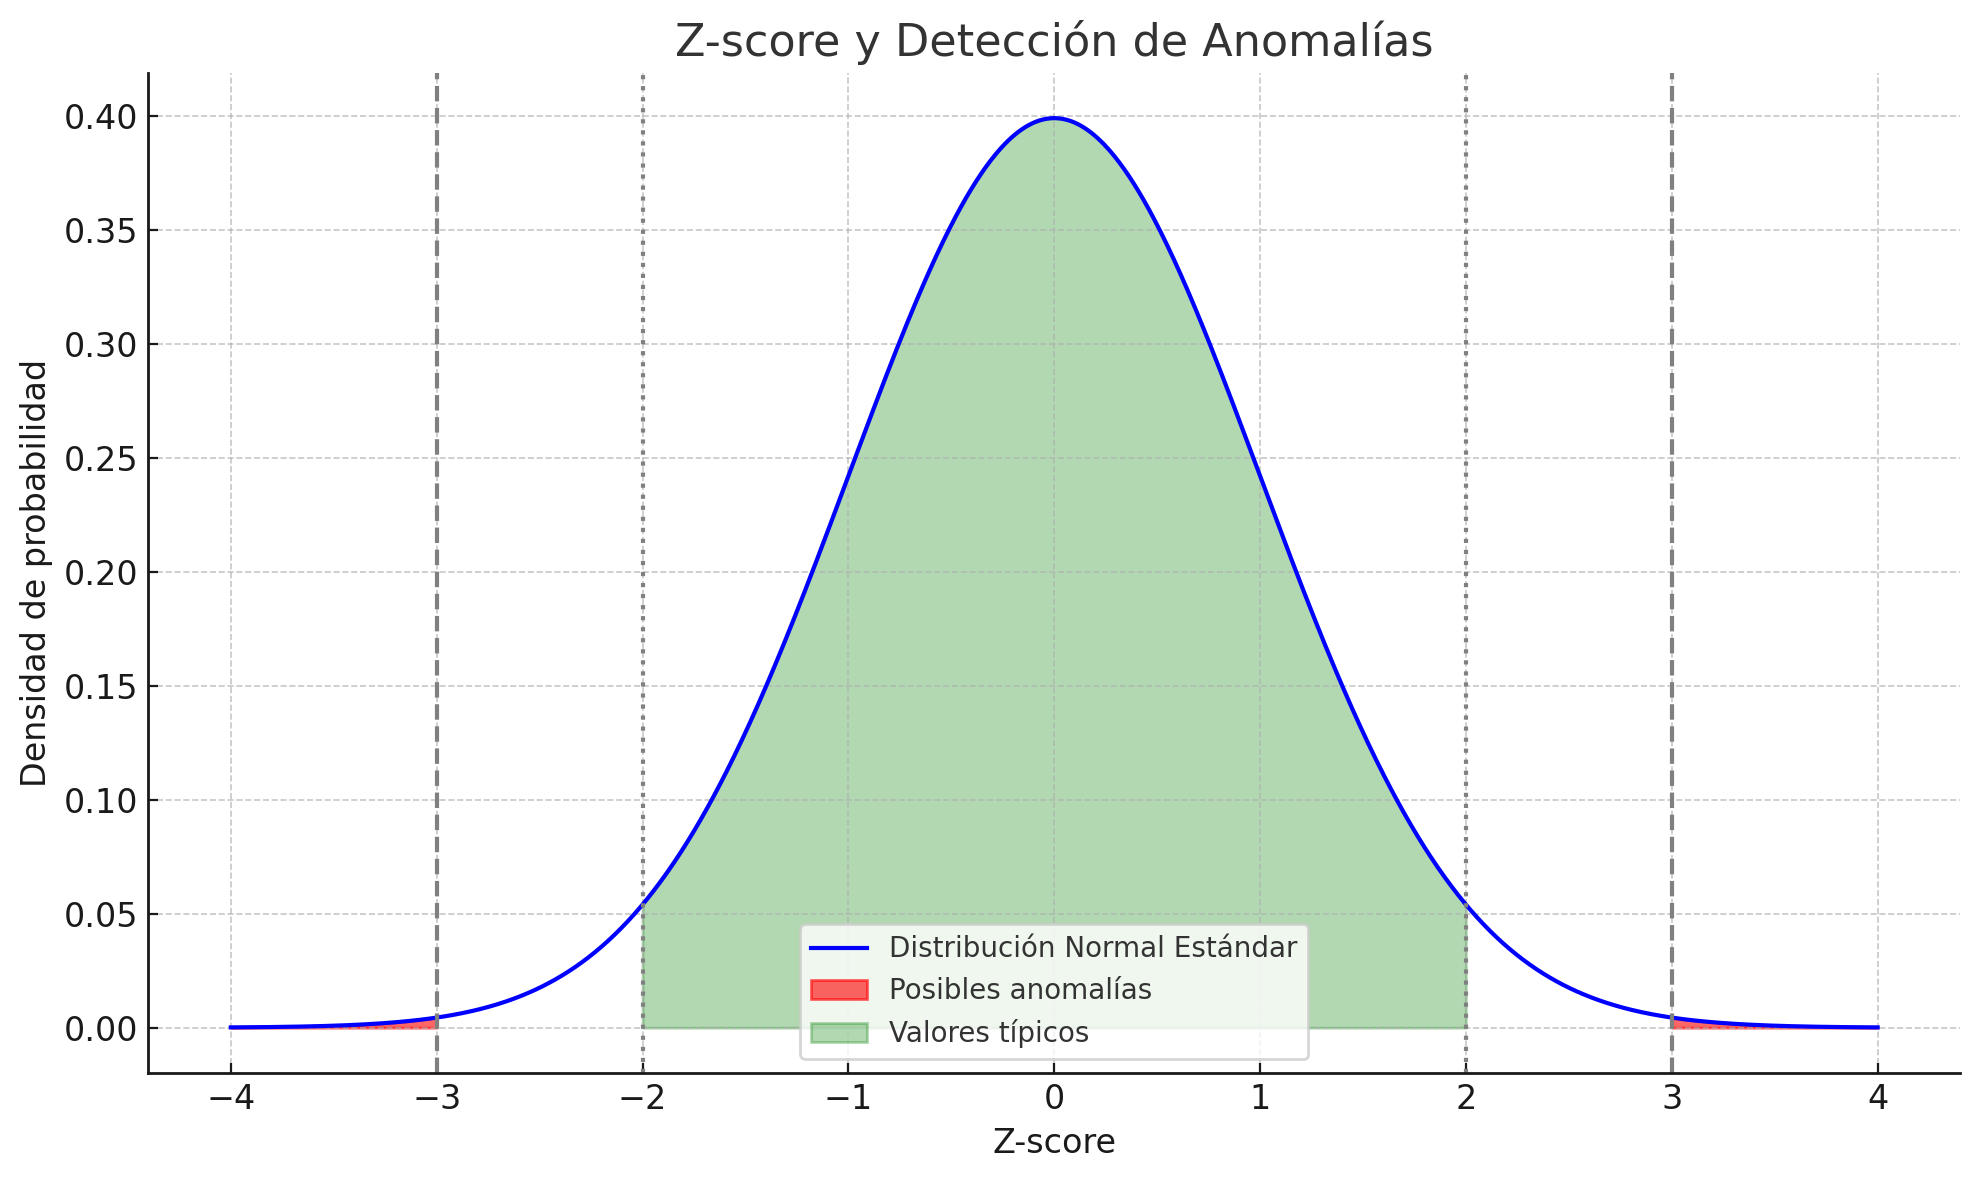

In [8]:
from IPython.display import Image

Image("anomalies.png", width=600) 

**Puntuación de Anomalía basada en Z-score**

Para transformar estos valores en una puntuación de anomalía por observación, se puede calcular el valor **máximo absoluto del Z-score** entre todas las características:

$$
\text{score}^{(i)} = \max_j \left| z_j^{(i)} \right|
$$

Este score representa **la desviación más extrema** (en cualquier dirección) que tiene una observación con respecto a la media de sus características. Es decir, si **alguna** de las características de la muestra está muy lejos del promedio, la muestra será considerada potencialmente anómala.

<br><br><br>

Una observación $i$ se considera una **anomalía** si:

$$
\text{score}^{(i)} > \tau
$$

donde $\tau$ es un umbral que puede fijarse manualmente (por ejemplo, 3 si asumimos normalidad) o ajustarse empíricamente usando un conjunto de validación.

<br><br><br>

**Nota:** Este método no devuelve directamente los Z-scores individuales, sino un valor agregado por muestra (el mayor Z-score absoluto). Aunque está basado en Z-scores, su salida es una **puntuación de anomalía**, no un valor estadístico interpretable por sí solo como un Z-score.


In [9]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, classification_report

In [10]:
def z_score_scores(X):
    mean = np.mean(X, axis=0) # Tomamos promedio de cada columna
    std = np.std(X, axis=0) # Tomamos desviación estándar de cada columna
    z = np.abs((X - mean) / std)
    return np.max(z, axis=1) # Encontramos el valor máximo de z-score por fila
    

In [11]:
# Calculamos los z-scores para los conjuntos de validación y prueba

def run_z_score(X_valid, X_test):
    z_scores_valid = z_score_scores(X_valid)
    z_scores_test = z_score_scores(X_test)
    return z_scores_valid, z_scores_test

z_scores_val, z_scores_test =  run_z_score(X_valid_scaled, X_test_scaled)

In [12]:
# Encontramos el mejor umbral para el z-score usando la validación

prec, rec, thresholds = precision_recall_curve(y_valid, z_scores_val)
f1s = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]

y_pred_z = (z_scores_test >= best_thresh).astype(int)

print(f'El mejor umbral para el z-score es: {best_thresh}')
print(f'El score f1 con este umbral es {f1_score(y_test, y_pred_z)}')


El mejor umbral para el z-score es: 17.72238395264908
El score f1 con este umbral es 0.19047619047619047


## Parte 2: K-means Clustering

La **detección de anomalías con K-means** es un enfoque basado en clustering o agrupamiento no supervisado. La intuición detrás del método es que la mayoría de los datos "normales" se agruparán en torno a ciertos patrones comunes, mientras que las observaciones anómalas se encontrarán alejadas de estos grupos.

K-means es un algoritmo que particiona el conjunto de datos en $k$ **clusters**, cada uno representado por su **centroide** (el promedio de los puntos asignados a ese cluster). Durante el entrenamiento, el algoritmo minimiza la suma de las distancias cuadradas entre cada punto y su centroide más cercano.

Una vez entrenado el modelo, es posible calcular para cada muestra su **distancia euclidiana** al centroide más cercano. Esta distancia se utiliza como una **puntuación de anomalía**: cuanto mayor sea la distancia, mayor será la probabilidad de que la muestra sea una anomalía.

<br><br>

Dado un conjunto de datos con $n$ características (columnas), y un conjunto de $k$ centroides $\{c_1, c_2, \dots, c_k\}$, la puntuación de anomalía de una muestra $x^{(i)}$ se define como:

$$
\text{score}^{(i)} = \min_{j=1, \dots, k} \left\| x^{(i)} - c_j \right\|_2
$$

donde:

- $x^{(i)}$ es el vector de características de la muestra $i$,
- $c_j$ es el centroide del cluster $j$,
- $\| \cdot \|_2$ representa la **norma euclidiana** (distancia L2).

<br>

Este valor mide qué tan "lejano" está el punto respecto a los patrones comunes (clusters) del conjunto de datos.

Una observación se considera una **anomalía** si su puntuación de distancia excede cierto **umbral $\tau$**:

$$
\text{anómalo si } \text{score}^{(i)} \geq \tau
$$

Este umbral puede establecerse manualmente, por ejemplo tomando un percentil alto de las distancias en los datos, o puede ajustarse empíricamente usando un conjunto de validación con etiquetas para maximizar métricas como el F1-score.




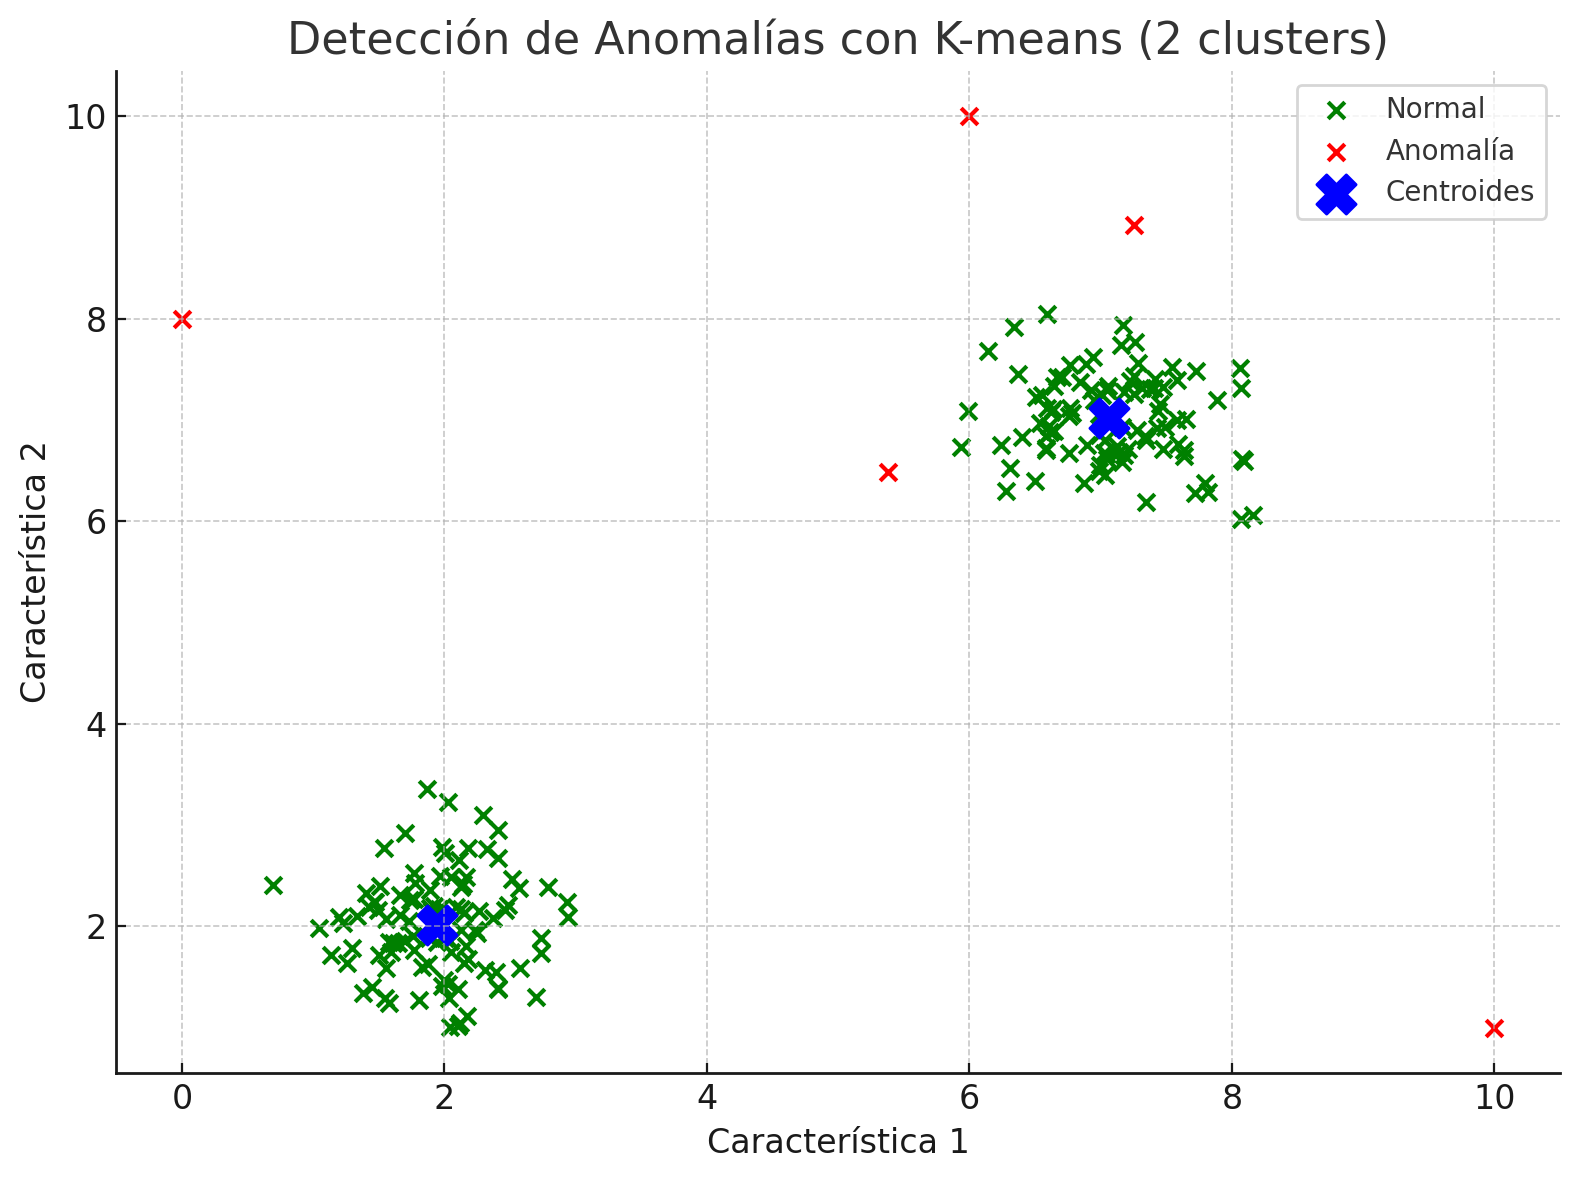

In [13]:
Image("kmeans.png", width=600) 

In [14]:
from sklearn.cluster import KMeans

In [15]:
# Función para calcular los scores de anomalía usando KMeans
# Se calcula la distancia de cada punto a su centroide más cercano
def kmeans_anomaly_scores(X, kmeans_model):
    centroids = kmeans_model.cluster_centers_
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.min(distances, axis=1)


In [16]:
# A = np.array([[1, 2], [3, 4], [5, 6]])
# A[:, np.newaxis]
# A[:, np.newaxis] - np.array([[1, 3]]).T
# np.linalg.norm(A[:, np.newaxis] - np.array([[10, 3]]).T, axis=2)

In [17]:
#Construimos el modelo KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled) 


,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [18]:
# Calculamos los scores de anomalía para los conjuntos de validación y prueba usando KMeans
k_scores_val = kmeans_anomaly_scores(X_valid_scaled, kmeans)
k_scores_test = kmeans_anomaly_scores(X_test_scaled, kmeans)


In [19]:
prec, rec, thresholds = precision_recall_curve(y_valid, k_scores_val)
f1s = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]

y_pred_kmeans = (k_scores_test >= best_thresh).astype(int)
print(f'El mejor umbral para el kMeans score es: {best_thresh}')
print(f'El score f1 con test y este umbral es {f1_score(y_test, y_pred_kmeans)}')

El mejor umbral para el kMeans score es: 12.311270626934832
El score f1 con test y este umbral es 0.4186046511627907


## Parte 3: Autoencoders y Detección de Anomalías


Los **autoencoders** son redes neuronales entrenadas para reconstruir su entrada. Se componen de dos partes:

- Un **codificador (encoder)** que reduce la dimensionalidad de los datos a una representación comprimida.
- Un **decodificador (decoder)** que intenta reconstruir la entrada original a partir de esa representación.

<br>

El objetivo del entrenamiento es minimizar el **error de reconstrucción**. Este error se puede utilizar como una **puntuación de anomalía**: si una muestra no se parece a lo que el modelo ha aprendido como "normal", el autoencoder tendrá dificultades para reconstruirla bien, y el error será alto.

<br><br>

Dado un vector de entrada $x^{(i)} \in \mathbb{R}^n$, y su reconstrucción $\hat{x}^{(i)}$, la puntuación de anomalía se define como:

$$
\text{score}^{(i)} = \frac{1}{n} \sum_{j=1}^{n} \left( x_j^{(i)} - \hat{x}_j^{(i)} \right)^2
$$

donde:

- $x^{(i)}$ es la muestra original,
- $\hat{x}^{(i)}$ es la reconstrucción producida por el autoencoder,
- $n$ es el número de características.

<br>

Una muestra se considera una **anomalía** si su error de reconstrucción supera un **umbral $\tau$** determinado (por ejemplo, ajustado en un conjunto de validación para optimizar el F1 score):

$$
\text{anómalo si } \text{score}^{(i)} \geq \tau
$$

<br>

**Intuición**

- Como la mayoría de los datos son normales, el autoencoder **aprende a representar bien solo los patrones comunes**.
- Las observaciones anómalas no siguen estos patrones, y por lo tanto, el modelo **no sabe cómo reconstruirlas** correctamente.
- Esto genera un **error de reconstrucción alto**, que sirve como **señal de que algo no encaja** con lo aprendido.

> **Conclusión:** Un error de reconstrucción alto sugiere que la muestra no se parece a los datos normales, y por tanto, puede ser una anomalía.


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random

In [21]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # makes convolutions deterministic
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [22]:
# Definimos la clase para la red neuronal autoencoder

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [23]:
def train_autoencoder(X_train_scaled, epochs=20, lr=1e-3):
    input_dim = X_train_scaled.shape[1]
    model = Autoencoder(input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=32, shuffle=True) # Nos permite entrenar el modelo en batches

    model.train()
    for epoch in range(epochs):
        for (x_batch,) in loader:
            optimizer.zero_grad()
            x_hat = model(x_batch)
            loss = criterion(x_hat, x_batch)
            loss.backward()
            optimizer.step()

    return model

In [24]:
model = train_autoencoder(X_train_scaled, epochs=20, lr=1e-3)

In [25]:
model.eval()
with torch.no_grad():
    X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    recon_valid = model(X_valid_tensor)
    recon_test = model(X_test_tensor)
    ae_scores_valid = torch.mean((X_valid_tensor - recon_valid) ** 2, dim=1).numpy()
    ae_scores_test = torch.mean((X_test_tensor - recon_test) ** 2, dim=1).numpy()

In [26]:
prec, rec, thresholds = precision_recall_curve(y_valid, ae_scores_valid)
f1s = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = f1s.argmax()
best_thresh = thresholds[best_idx]

y_pred_nn = (ae_scores_test >= best_thresh).astype(int)

print(f"Mejor umbral: {best_thresh:.4e}")
print(f"F1 en testeo: {f1_score(y_test, y_pred_nn):.4f}")

Mejor umbral: 2.3123e-01
F1 en testeo: 0.4500
